## A Case Study



### Problem statment

The plot starts at a fast-paced startup. The company is rapidly expanding, and the marketing team is looking for ways to enhance sales from existing customers by encouraging them to purchase more. The fundamental idea is to use incentives, in this case a discount, to unlock the potential of the client base. Of course, we want to know how the discount affected the customer's behavior. Nonetheless, they do not want to waste money by providing ineffective discounts to people. It is always about return on investment (ROI).

In [1]:
import arviz as az
import bambi as bmb
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.stats import randint, uniform
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV

#### Data

In [2]:
data_path = "CI_data/sales_data.csv"
data = pd.read_csv(data_path)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   visits           700 non-null    int64  
 1   discount         700 non-null    int64  
 2   is_loyal         700 non-null    int64  
 3   sales            700 non-null    float64
 4   sales_per_visit  700 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 27.5 KB


#### Exploratory Data Analysis

In [5]:
## looking at the share of customers which received a discount

data["discount"].value_counts() / len(data)

1    0.74
0    0.26
Name: discount, dtype: float64

In [6]:
data["is_loyal"].value_counts() / len(data)

1    0.75
0    0.25
Name: is_loyal, dtype: float64

For beterr understanding we plot them using cross-tab table 

In [7]:
pd.crosstab(data["discount"], data["is_loyal"])

is_loyal,0,1
discount,,
0,175,7
1,0,518


It should be noted that all customers who received a discount are loyal (as necessary), and that there are loyal users who did not obtain a discount. This is due to their remarkable sales figures. Let us check this:


In [8]:
data.query("discount == 0").sort_values(by="sales", ascending=False)

,visits,discount,is_loyal,sales,sales_per_visit
566,33,0,1,31.721689,0.961263
204,33,0,1,28.311111,0.857912
365,33,0,1,28.081634,0.850959
49,33,0,1,27.790644,0.842141
280,29,0,1,27.581146,0.951074
...,...,...,...,...,...
535,11,0,0,7.619325,0.692666
630,11,0,0,7.293413,0.663038
277,10,0,0,7.080501,0.708050
529,3,0,0,4.241497,1.413832


Good news...!, The loyal customers are on top 

Text(0.5, 1.05, 'Sales Distribution by Discount Group')

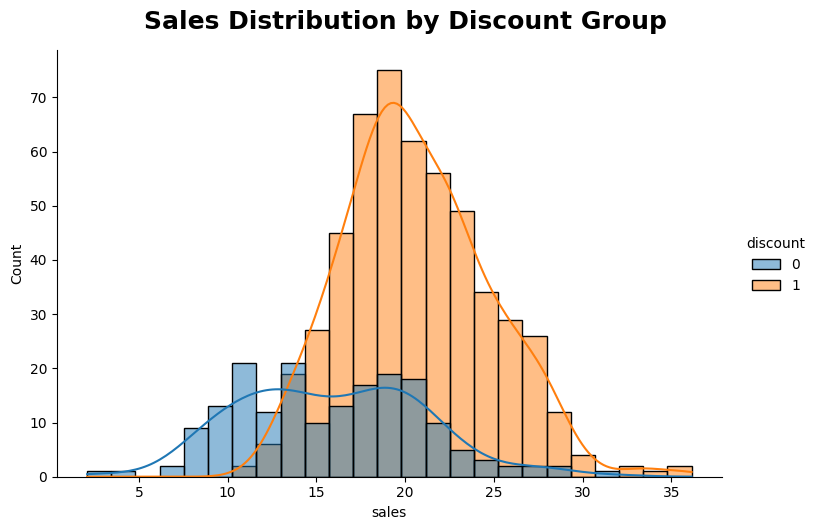

In [9]:
g = sns.displot(
    data=data,
    x="sales",
    kind="hist",
    hue="discount",
    kde=True,
    fill=True,
    height=5,
    aspect=1.5,
)
g.fig.suptitle(
    "Sales Distribution by Discount Group", y=1.05, fontsize=18, fontweight="bold"
)

#### Difference in Means as Baseline model 

we can use the difference in means (DIM) as a baseline for the ATE estimation. The DIM is the difference in the mean of the target variable between the treatment and control group.

In [10]:
(
    data.query("discount == 1")["sales"].mean()
    - data.query("discount == 0")["sales"].mean()
)

4.799150094279289

Wow! We see 4.8 $ mean uplift!, Which is good 

When they considered the reasons for such a large increase, I got to know the discount assignment was not random. It was determined by the number of online visits (from the marketing team). This suggests that the discount group is not totally equivalent to the control group! They decide to graph sales vs web visits by discount group:


Text(0.5, 1.05, 'Sales vs. Visits')

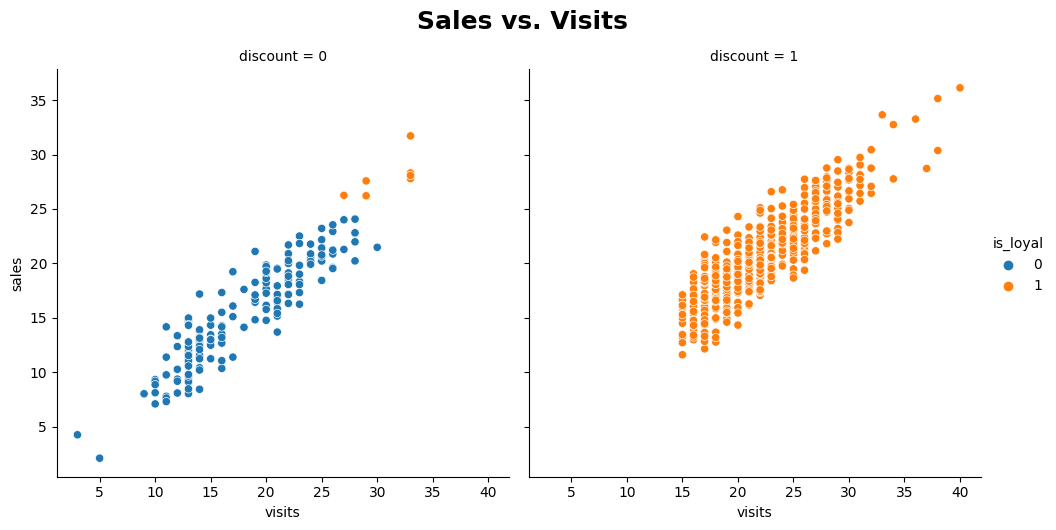

In [11]:
g = sns.relplot(data=data, x="visits", y="sales", hue="is_loyal", col="discount")
g.fig.suptitle("Sales vs. Visits", y=1.05, fontsize=18, fontweight="bold")

In [13]:
(
    data.query("discount == 1")["sales_per_visit"].mean()
    - data.query("discount == 0")["sales_per_visit"].mean()
)

0.07705031597862955

The results are completely different than what we seen, I would like to consider control for loyalty because the discount strategy was supposed to characterize (target?) loyal customers

Text(0.5, 1.05, 'Sales distribution by discount and loyalty')

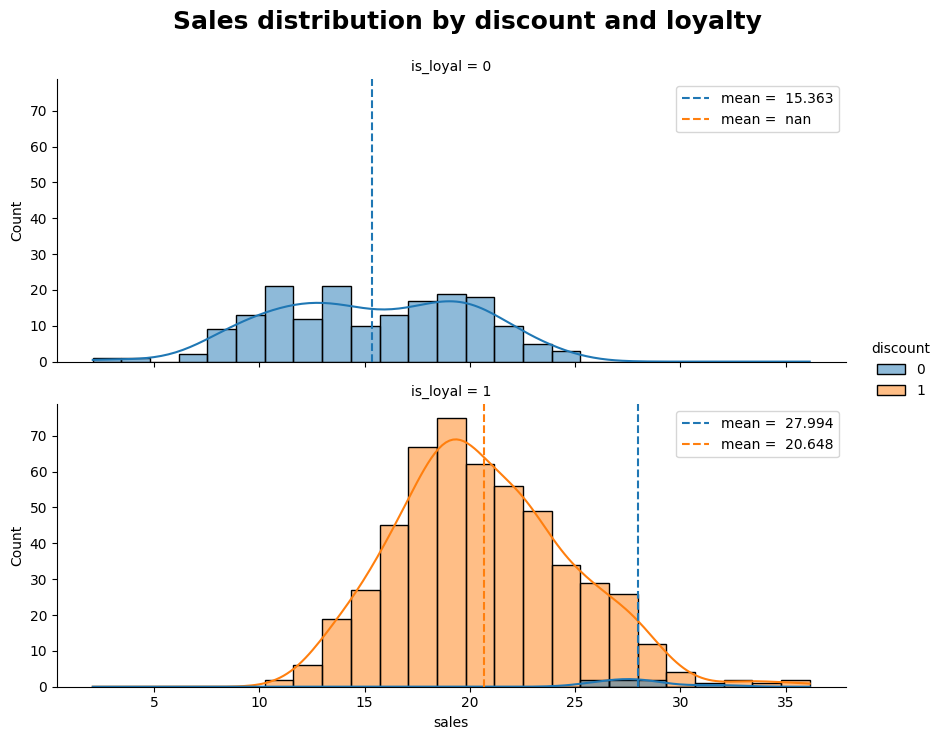

In [14]:
g = sns.displot(
    data=data,
    x="sales",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales"].mean()
        ax.axvline(
            x=df.query(f"discount == {discount}")["sales"].mean(),
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle(
    "Sales distribution by discount and loyalty", y=1.05, fontsize=18, fontweight="bold"
)


Wow, that was truly unexpected! They made a startling discovery: loyal customers generated significantly greater sales compared to non-loyal customers when it came to the non-discounted group. This finding leaves us puzzled. It's evident that there exists a distinct sales gap between users who are loyal and those who aren't, all within the context of no discounts being applied.

In [15]:
(
    data.query("discount == 0 & is_loyal == 1")["sales"].mean()
    - data.query("discount == 0 & is_loyal == 0")["sales"].mean()
)

12.631180501353883

The plots above did not factor the visits variable. Hence, we ploted on the sales_per_visit variable:

Text(0.5, 1.05, 'Sales per visit distribution by discount and loyalty')

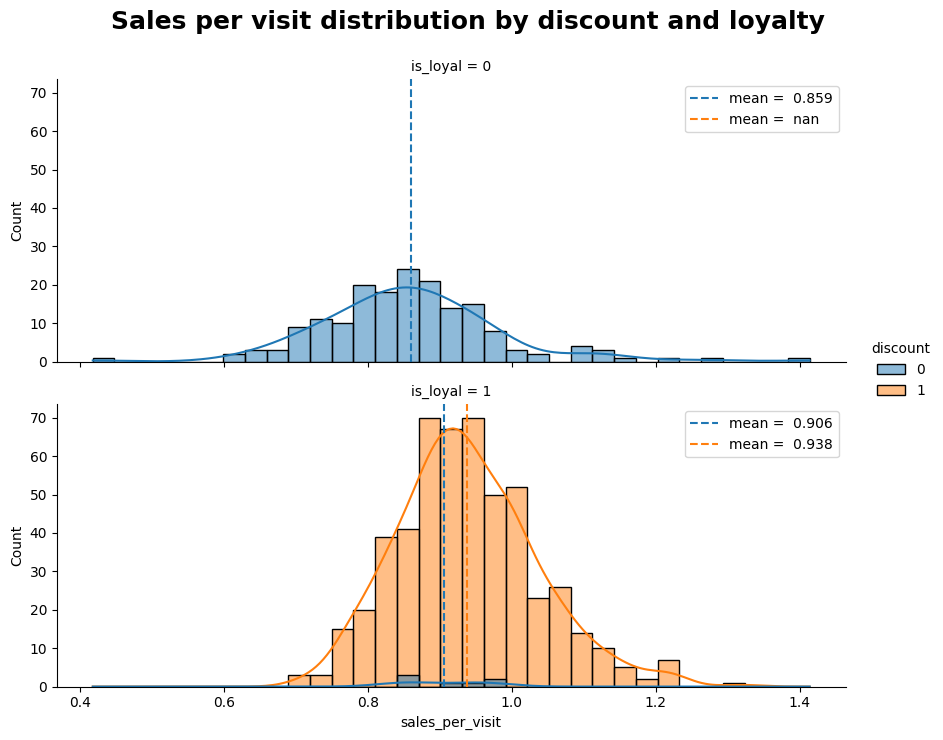

In [16]:
g = sns.displot(
    data=data,
    x="sales_per_visit",
    hue="discount",
    row="is_loyal",
    kde=True,
    height=3.5,
    aspect=2.5,
)

for i, ax in enumerate(g.axes.flatten()):
    df = data.query(f"is_loyal == {i}")
    for discount in range(2):
        mean = df.query(f"discount == {discount}")["sales_per_visit"].mean()
        ax.axvline(
            x=mean,
            color=f"C{discount}",
            linestyle="--",
            label=f"mean = {mean: .3f}",
        )
        ax.legend(loc="upper right")

g.fig.suptitle(
    "Sales per visit distribution by discount and loyalty",
    y=1.05,
    fontsize=18,
    fontweight="bold",
)


We got three different results from descriptive analysis, but we dont know which is right upliftment, I wanna try to model the data with Linear Model where I can include all the variables as covariates

#### Bayesian linear regression model

In [17]:
# set priors
complete_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "visits": bmb.Prior(
        "Gamma", mu=0.9, sigma=0.3
    ),  # visits has s positive relation with sales
    "discount": bmb.Prior("Normal", mu=0, sigma=5),
    "is_loyal": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("Exponential", lam=1 / 2),
}
# model sales as a function of discount, visits and loyalty
complete_model = bmb.Model(
    formula="sales ~ discount + visits + is_loyal",
    data=data,
    family="gaussian",
    link="identity",
    priors=complete_model_priors,
)


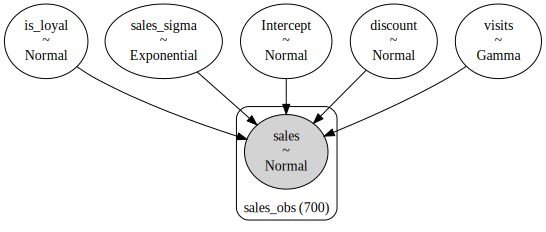

In [18]:
complete_model.build()
complete_model.graph()

In [19]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


seed: int = sum(map(ord, "causality"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

Sampling: [Intercept, discount, is_loyal, sales, sales_sigma, visits]


Text(0.5, 1.0, "Model's Prior Predictive")

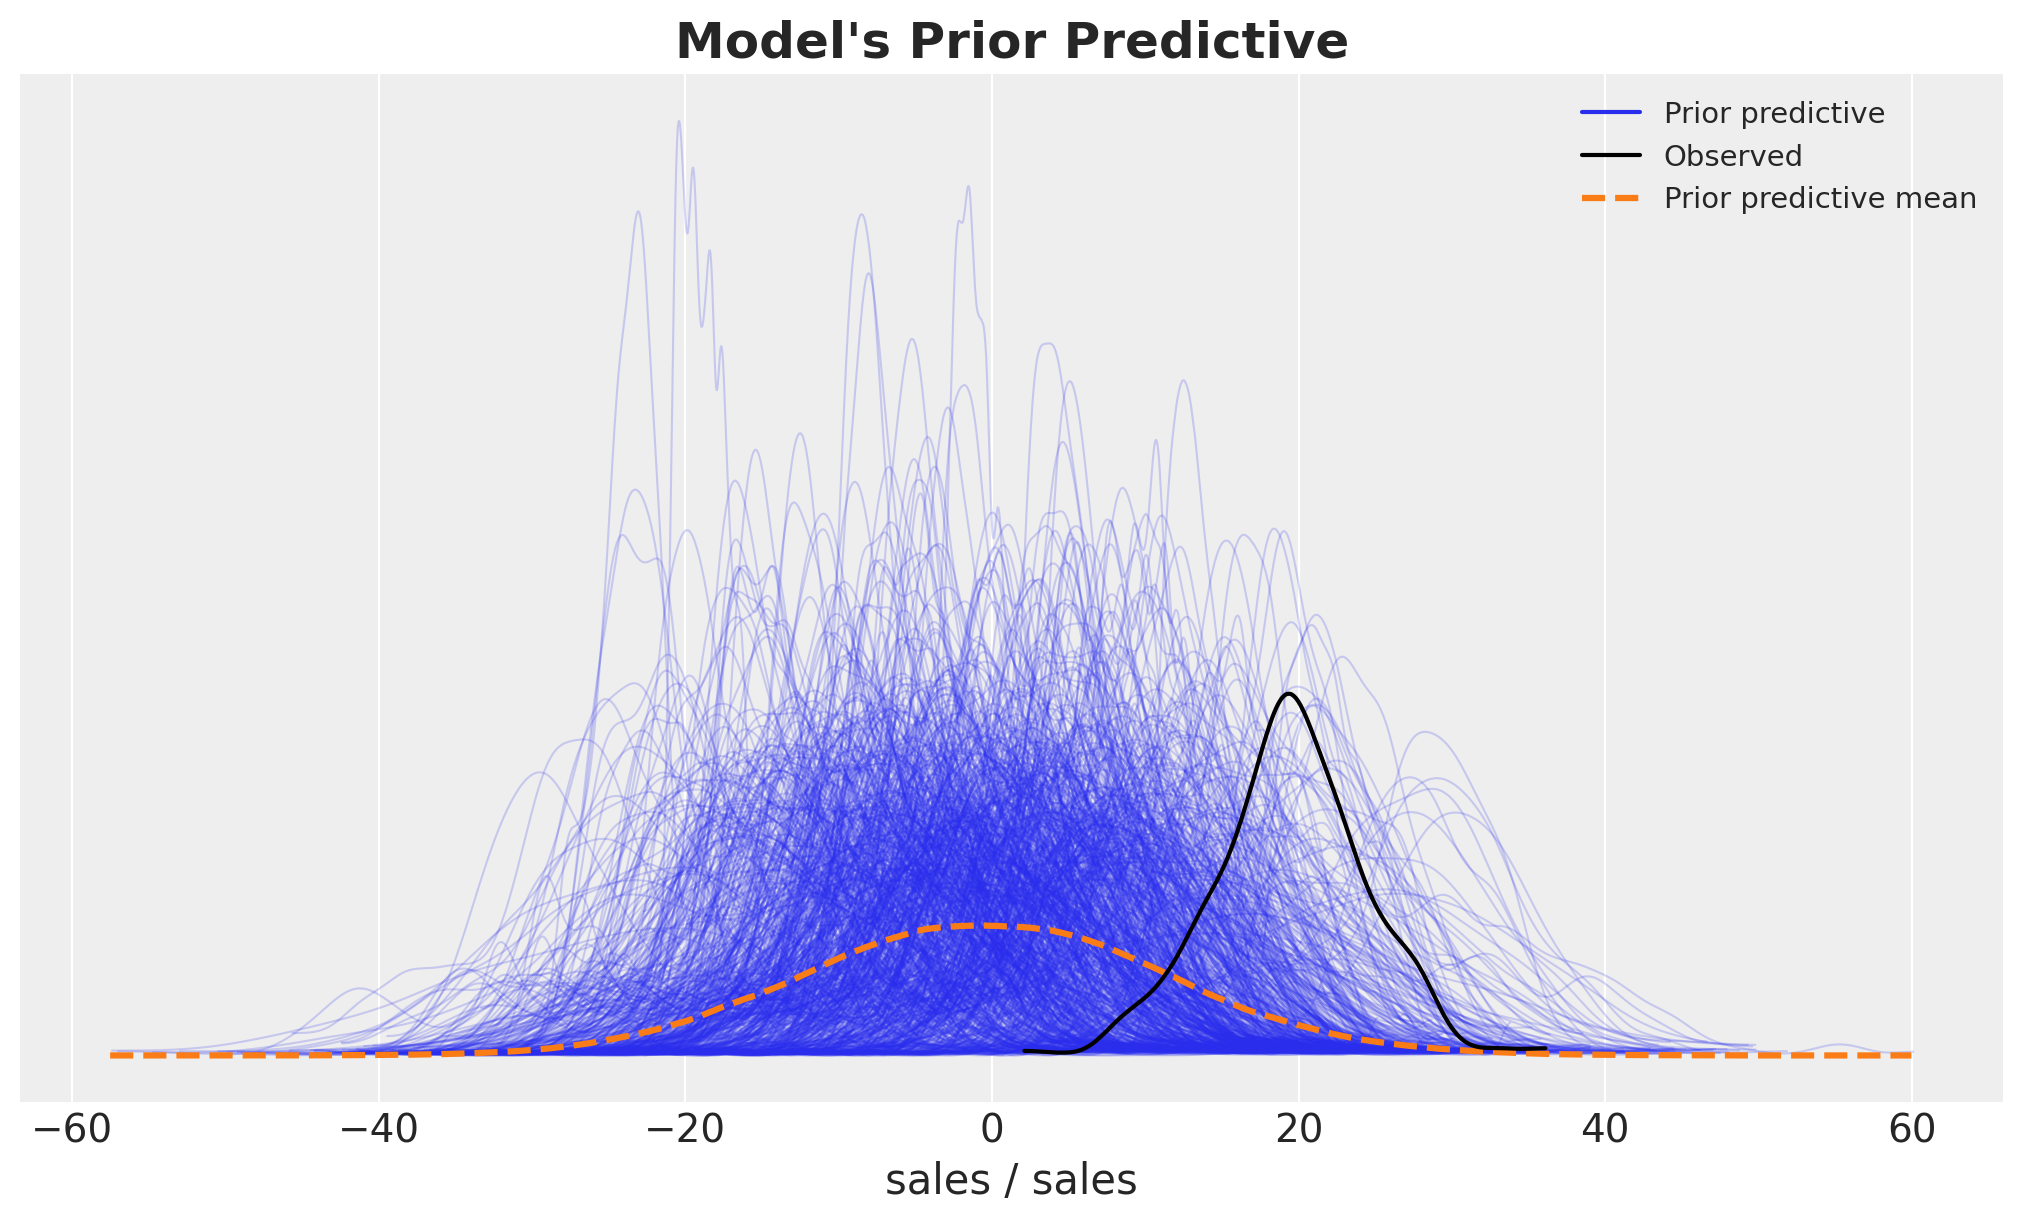

In [21]:
complete_model_prior_predictive = complete_model.prior_predictive(
    draws=1_000, random_seed=rng
)
fig, ax = plt.subplots()
az.plot_ppc(data=complete_model_prior_predictive, group="prior", kind="kde", ax=ax)
ax.set_title(label="Model's Prior Predictive", fontsize=18, fontweight="bold")

In [22]:
complete_model_idata = complete_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)
c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Compiling...
Compilation time =  0:00:05.247403
Sampling...


Compiling.. :   0%|          | 0/5000 [00:00<?, ?it/s]













Running chain 0:   0%|          | 0/5000 [00:04<?, ?it/s]





Running chain 0:  10%|█         | 500/5000 [00:04<00:01, 4356.07it/s]





Running chain 0:  20%|██        | 1000/5000 [00:05<00:00, 4383.23it/s]





Running chain 0:  30%|███       | 1500/5000 [00:05<00:00, 3988.06it/s]








Running chain 0:  40%|████      | 2000/5000 [00:05<00:00, 3746.17it/s]



Running chain 0:  50%|█████     | 2500/5000 [00:05<00:00, 3496.63it/s]





Running chain 0:  60%|██████    | 3000/5000 [00:05<00:00, 3432.35it/s]




Running chain 0:  70%|███████   | 3500/5000 [00:05<00:00, 3427.45it/s]





Running chain 0:  80%|████████  | 4000/5000 [00:05<00:00, 3330.96it/s]





Running chain 0:  90%|█████████ | 4500/5000 [00:06<00:00, 3290.56it/s]





Running chain 0: 100%|██████████| 5000/5000 [00:06<00:00, 3264.97it/s]



Running chain 4: 100%|██████████| 5000/5000 [00:06<00:00, 763.70it/s] 


Sampling time =  0:00:07.235325
Transforming variables...
Transformation time =  0:00:00.067222


In [23]:
az.summary(data=complete_model_idata)

c:\Users\raviteja.kurva\Anaconda3\envs\pm3env\lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.118,0.304,0.559,1.701,0.002,0.002,16468.0,14142.0,1.0
discount,-0.274,0.715,-1.619,1.064,0.007,0.005,9425.0,10367.0,1.0
is_loyal,2.260,0.738,0.897,3.674,0.008,0.005,9261.0,10220.0,1.0
sales_sigma,1.892,0.051,1.799,1.989,0.000,0.000,14787.0,12054.0,1.0
visits,0.792,0.015,0.765,0.821,0.000,0.000,14980.0,12028.0,1.0


Text(0.5, 1.0, 'Posterior distribution of discount coefficient - Linear model')

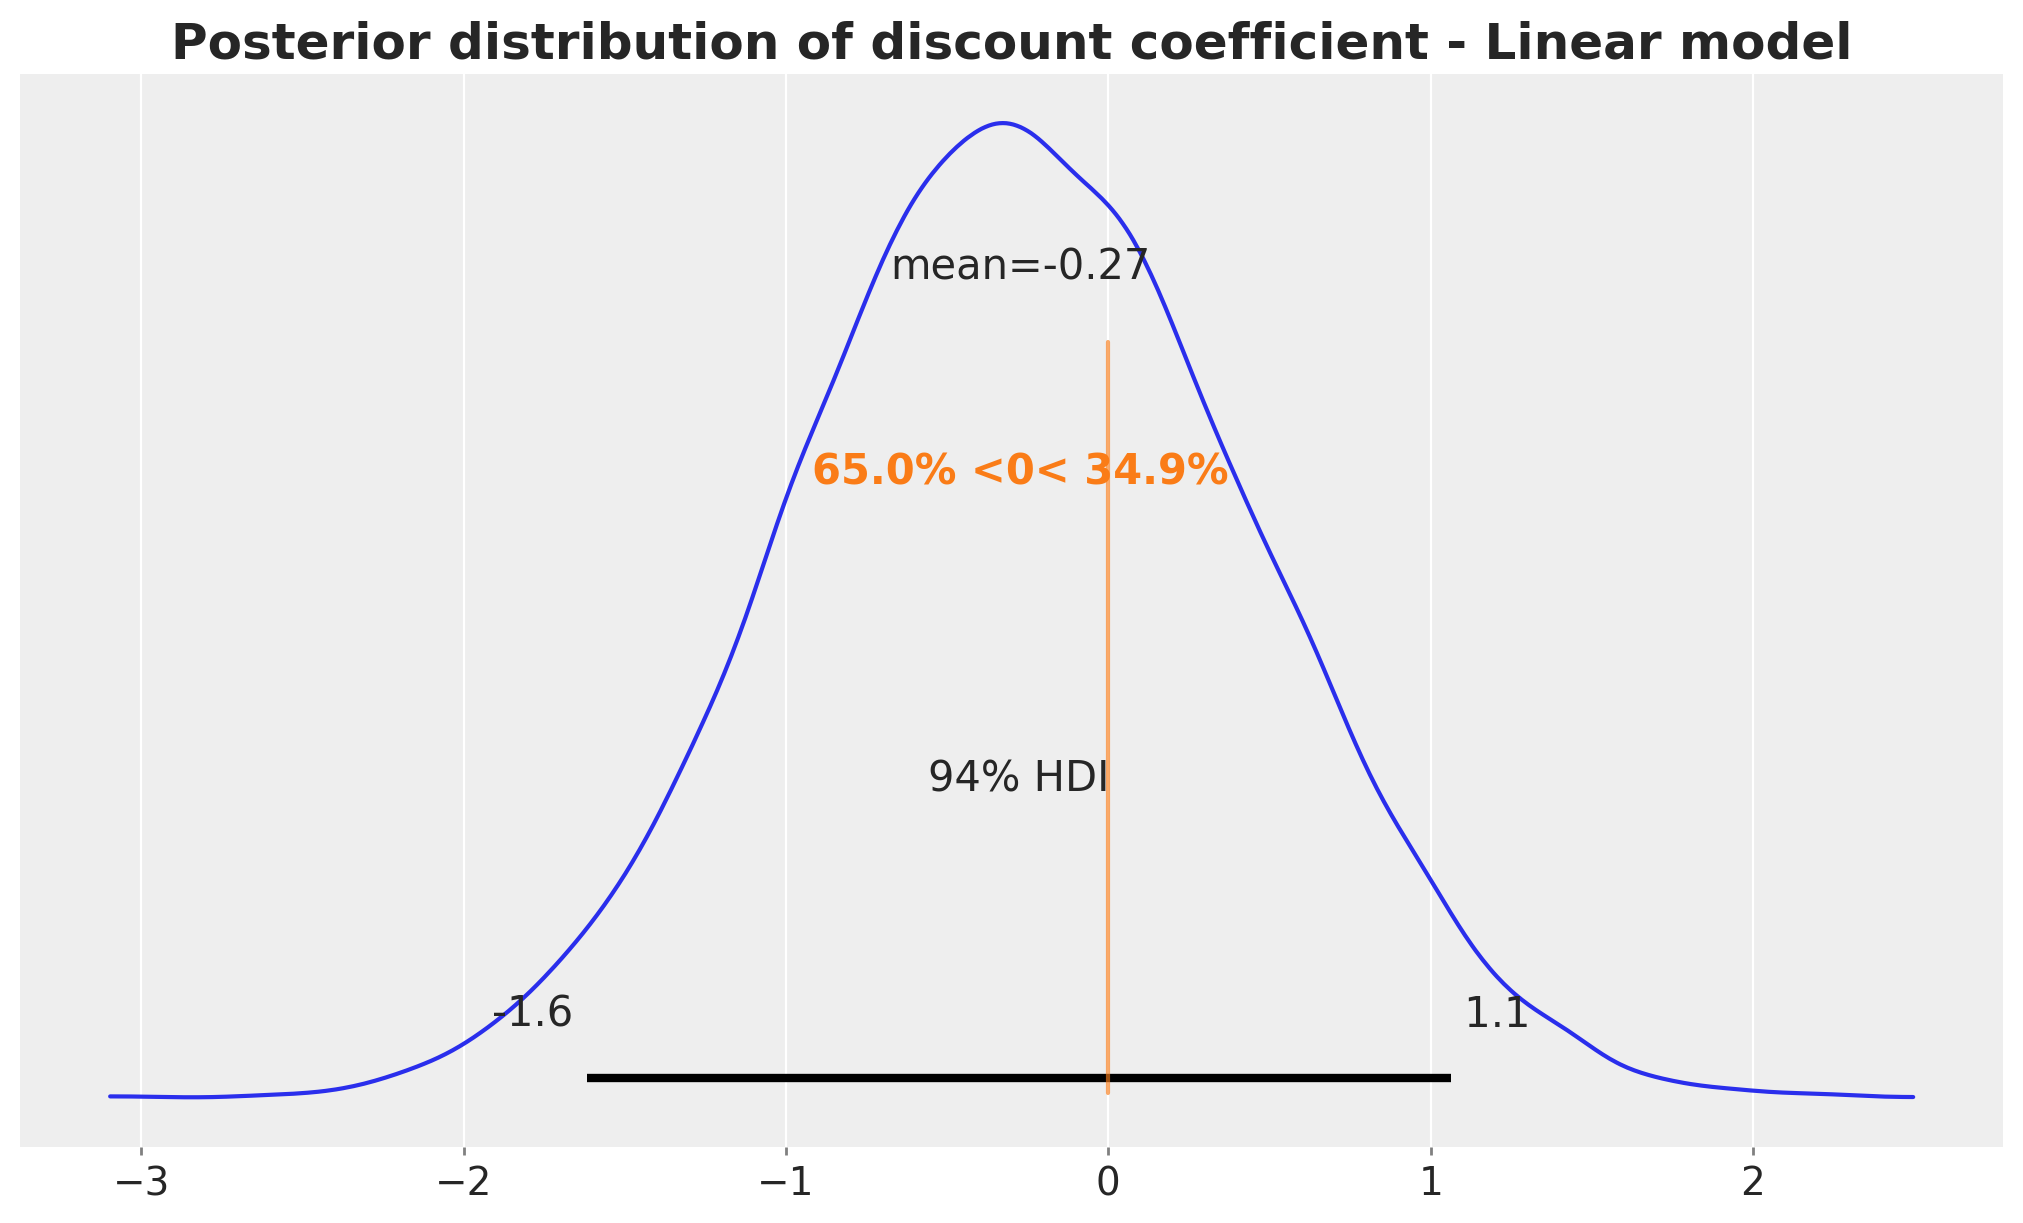

In [24]:
fig, ax = plt.subplots()
az.plot_posterior(data=complete_model_idata, var_names=["discount"], ref_val=0, ax=ax)
ax.set_title(
    label="Posterior distribution of discount coefficient - Linear model",
    fontsize=18,
    fontweight="bold",
)

##### From the linear model with all variable we got the slight negative effect

#### Posterior Predictive Checks

Text(0.5, 1.0, 'Simple linear Model - Posterior Predictive')

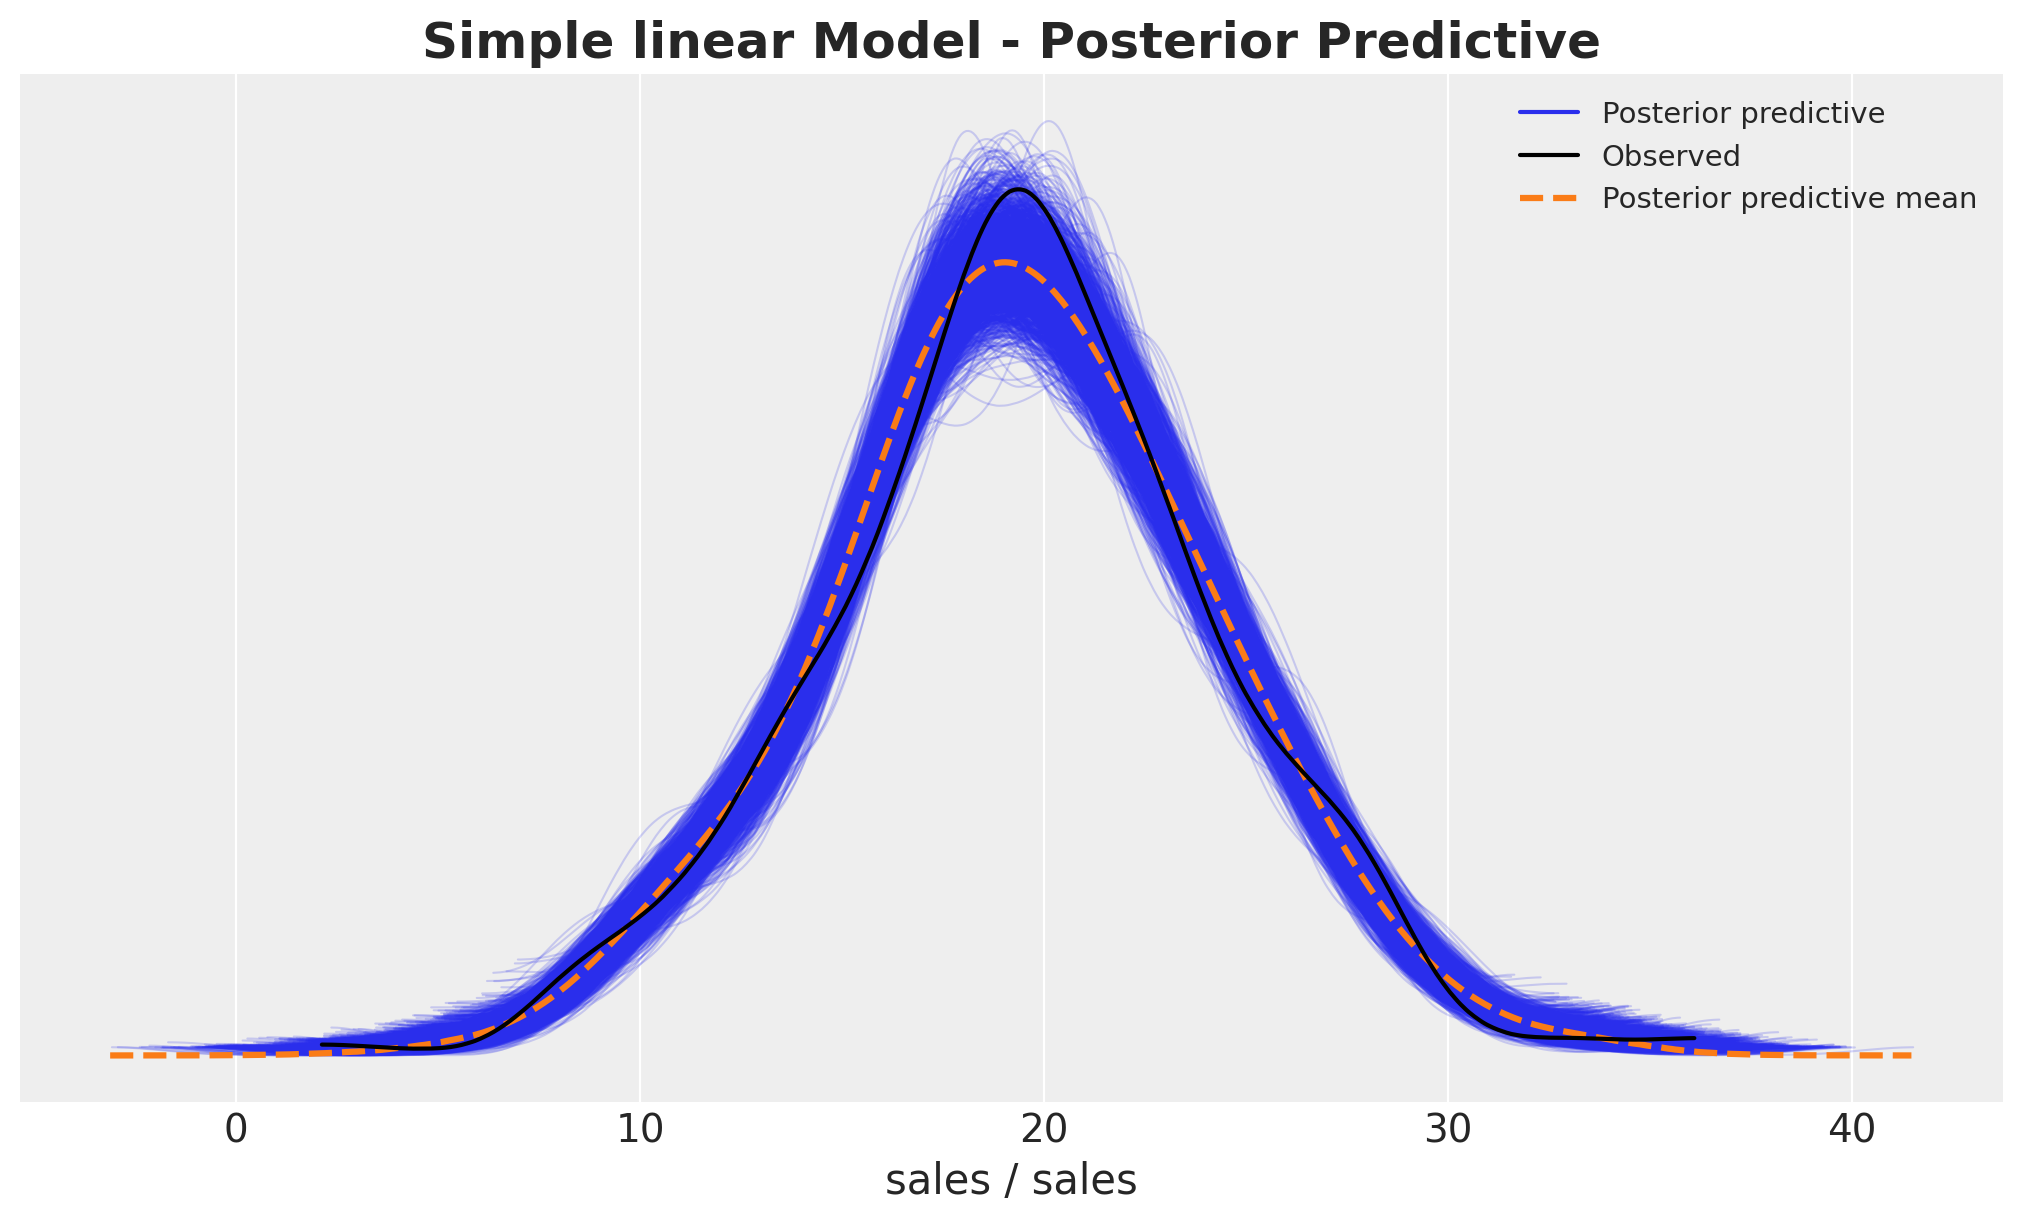

In [25]:
complete_model.predict(idata=complete_model_idata, kind="pps", inplace=True)


fig, ax = plt.subplots()
az.plot_ppc(
    data=complete_model_idata,
    group="posterior",
    kind="kde",
    num_pp_samples=2_000,
    random_seed=seed,
    ax=ax,
)
ax.set_title(
    label="Simple linear Model - Posterior Predictive", fontsize=18, fontweight="bold"
)

 The model posterior predictive looks good. The model seems to be able to capture the data.

#### Stop the discount strategy as on average it provides less than 1$ additional sales, which implies a negative ROI.